<a href="https://colab.research.google.com/github/sharmin133/Rice-Leaf/blob/main/mobilenetv1%2Bclahe%2Bprewitt_final_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import MobileNet


In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS=3
EPOCHS=25

In [ ]:
dataset= tf.keras.preprocessing.image_dataset_from_directory(
    r"/content/drive/MyDrive/Final Thesis/Feature Extraction/Prewitt edge detection/CHAHE+prewitt",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 7471 files belonging to 5 classes.


In [ ]:
class_names= dataset.class_names
print(class_names)
len(dataset)

['Bacterialblight', 'Blast', 'Brownspot', 'Tungro', '_Healthy']


234

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 224, 224, 3)
[0 4 3 3 0 1 2 0 2 4 0 2 0 2 4 4 4 3 3 0 2 0 2 0 3 2 3 2 4 2 3 1]


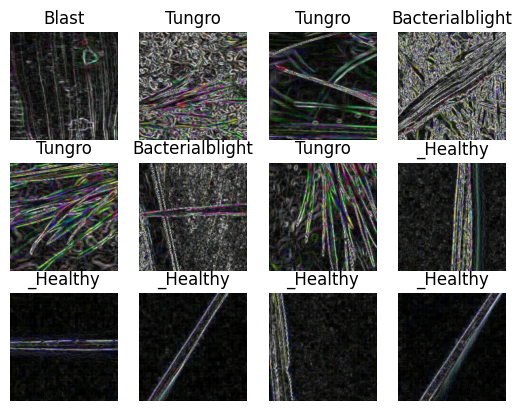

In [ ]:
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.7, val_split=0.1, test_split=0.2, shuffle=True, shuffle_size=10000):
    assert (train_split +  val_split+test_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds
train_ds, val_ds,test_ds= get_dataset_partitions_tf(dataset)
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

163
23
48


In [ ]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# Determine the number of classes in your dataset
n_classes = len(class_names)

# Create the MobileNet model
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS),pooling='avg')
model =Sequential()
model.add(base_model)

model.add(Dropout(0.25))
model.add(Dense(256, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))

17225924/17225924 [==============================] - 1s 0us/step


In [ ]:
base_model.trainable=False

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 1024)              3228864   
 onal)                                                           
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 3492549 (13.32 MB)
Trainable params: 263685 (1.01 MB)
Non-trainable params: 3228864 (12.32 MB)
_________________________________________________________________


In [ ]:
model.compile(
    optimizer = Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
     history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=25,
)

Epoch 1/25
163/163 [==============================] - 363s 100ms/step - loss: 0.8893 - accuracy: 0.6505 - val_loss: 0.6185 - val_accuracy: 0.7330
Epoch 2/25
163/163 [==============================] - 4s 23ms/step - loss: 0.6636 - accuracy: 0.7342 - val_loss: 0.5669 - val_accuracy: 0.7733
Epoch 3/25
163/163 [==============================] - 4s 23ms/step - loss: 0.5863 - accuracy: 0.7678 - val_loss: 0.5201 - val_accuracy: 0.7983
Epoch 4/25
163/163 [==============================] - 4s 22ms/step - loss: 0.5581 - accuracy: 0.7805 - val_loss: 0.4447 - val_accuracy: 0.8456
Epoch 5/25
163/163 [==============================] - 4s 22ms/step - loss: 0.4953 - accuracy: 0.8067 - val_loss: 0.4819 - val_accuracy: 0.7955
Epoch 6/25
163/163 [==============================] - 4s 22ms/step - loss: 0.4846 - accuracy: 0.8105 - val_loss: 0.3962 - val_accuracy: 0.8540
Epoch 7/25
163/163 [==============================] - 4s 22ms/step - loss: 0.4706 - accuracy: 0.8088 - val_loss: 0.3534 - val_accuracy: 0.8

In [ ]:
scores = model.evaluate(test_ds)

48/48 [==============================] - 13s 20ms/step - loss: 0.1254 - accuracy: 0.9655


In [ ]:
scores

[0.12535828351974487, 0.9654948115348816]

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

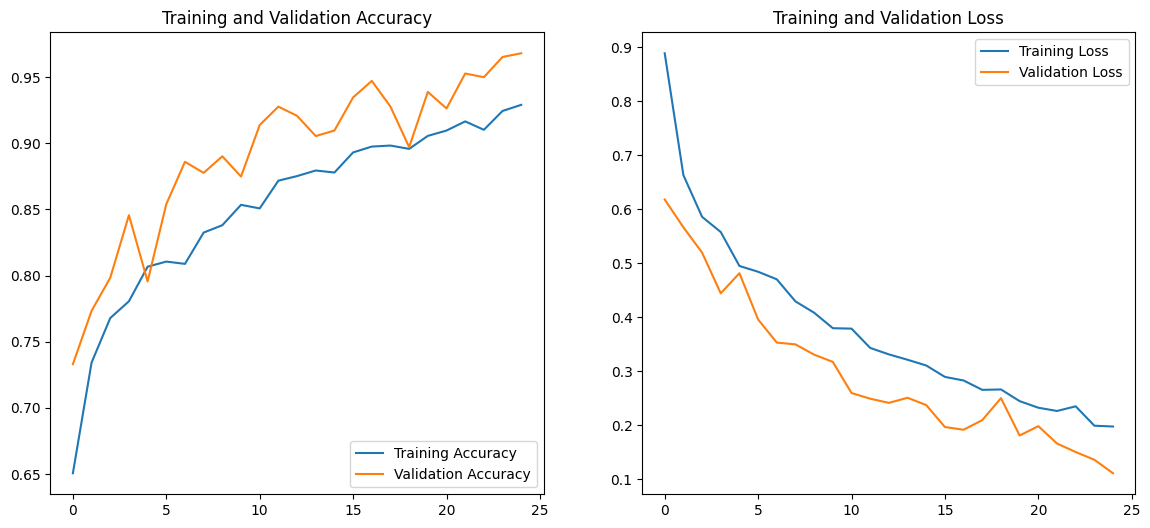

In [ ]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Bacterialblight
1/1 [==============================] - 1s 514ms/step
predicted label: Bacterialblight


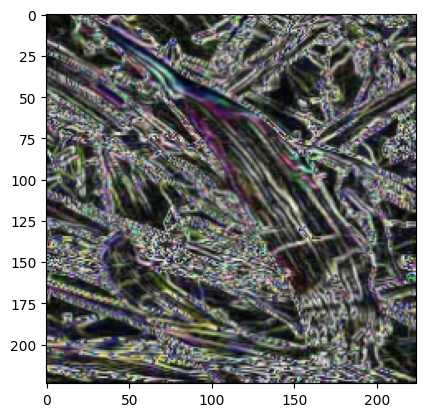

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

48/48 [==============================] - 1s 17ms/step


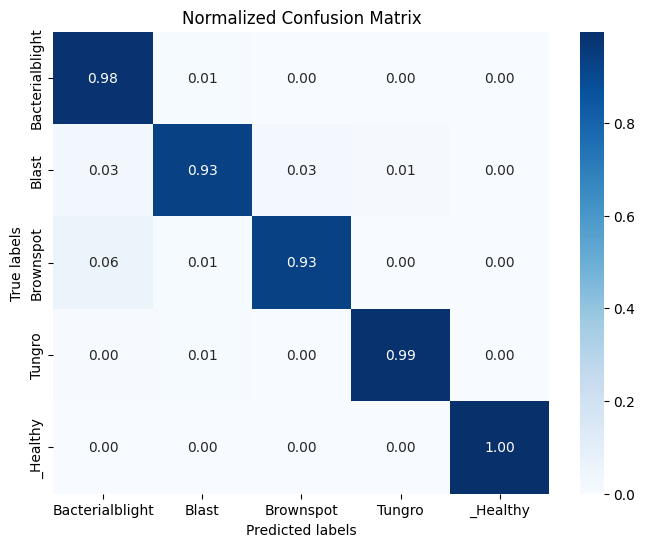

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict the labels for the test dataset
test_images = []
test_labels = []

for images, labels in test_ds:
    test_images.append(images.numpy())
    test_labels.append(labels.numpy())

test_images = np.concatenate(test_images)
test_labels = np.concatenate(test_labels)
predicted_labels = np.argmax(model.predict(test_images), axis=-1)

# Create confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)

# Normalize confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a figure for the plot
plt.figure(figsize=(8, 6))

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Normalized Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
target_names = class_names
report = classification_report(test_labels, predicted_labels, target_names=target_names)
print("Classification Report:\n", report)

Classification Report:
                  precision    recall  f1-score   support

Bacterialblight       0.91      0.98      0.94       306
          Blast       0.97      0.93      0.95       316
      Brownspot       0.97      0.93      0.95       333
         Tungro       0.98      0.99      0.98       254
       _Healthy       1.00      1.00      1.00       327

       accuracy                           0.97      1536
      macro avg       0.97      0.97      0.97      1536
   weighted avg       0.97      0.97      0.97      1536

